In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import nltk
import math
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [2]:
# Data taken from https://www.kaggle.com/shahir/protein-data-set
# This is a protein data set retrieved from Research Collaboratory for Structural Bioinformatics (RCSB) Protein Data Bank (PDB).

In [3]:
df1 = pd.read_csv('pdb_data_no_dups.csv')
df2 = pd.read_csv('pdb_data_seq.csv')
df1.head(10)

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
3,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0
4,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0
5,102M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,1.84,18010.64,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
6,103D,DNA,SOLUTION NMR,DNA,24,NaN,7502.93,NaN,NaN,NaN,NaN,NaN,NaN,1994.0
7,103L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,167,1.90,19092.72,NaN,NaN,2.70,54.46,NaN,NaN,1993.0
8,103M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18093.78,NaN,NaN,3.09,60.30,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
9,104D,DNA-RNA HYBRID,SOLUTION NMR,DNA/RNA Hybrid,24,NaN,7454.78,NaN,NaN,NaN,NaN,NaN,NaN,1995.0


In [4]:
df2.head()

,structureId,chainId,sequence,residueCount,macromoleculeType
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,A,CGCGAATTCGCG,24,DNA
3,101D,B,CGCGAATTCGCG,24,DNA
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein


In [5]:
df1.columns

Index(['structureId', 'classification', 'experimentalTechnique',
       'macromoleculeType', 'residueCount', 'resolution',
       'structureMolecularWeight', 'crystallizationMethod',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'pdbxDetails', 'phValue', 'publicationYear'],
      dtype='object')

In [6]:
df2.columns

Index(['structureId', 'chainId', 'sequence', 'residueCount',
       'macromoleculeType'],
      dtype='object')

In [7]:
df1.shape

(141401, 14)

In [8]:
df2.shape

(467304, 5)

In [9]:
df3 = pd.merge(df1, df2, on=['structureId','macromoleculeType','residueCount'])

In [10]:
df3.shape

(471149, 16)

In [11]:
df3.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,A,CCGGCGCCGG
1,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,B,CCGGCGCCGG
2,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,A,CGCGAATTCGCG
3,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,B,CGCGAATTCGCG
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [12]:
df3.tail()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
471144,9XIA,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,388,1.9,43542.29,NaN,NaN,2.79,55.93,NaN,NaN,1989.0,A,MNYQPTPEDRFTFGLWTVGWQGRDPFGDATRRALDPVESVQRLAEL...
471145,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.4,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,A,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
471146,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.4,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,B,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
471147,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.4,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,C,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
471148,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.4,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,D,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...


In [13]:
df3.dtypes

structureId                  object
classification               object
experimentalTechnique        object
macromoleculeType            object
residueCount                  int64
resolution                  float64
structureMolecularWeight    float64
crystallizationMethod        object
crystallizationTempK        float64
densityMatthews             float64
densityPercentSol           float64
pdbxDetails                  object
phValue                     float64
publicationYear             float64
chainId                      object
sequence                     object
dtype: object

In [14]:
df3.columns

Index(['structureId', 'classification', 'experimentalTechnique',
       'macromoleculeType', 'residueCount', 'resolution',
       'structureMolecularWeight', 'crystallizationMethod',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'pdbxDetails', 'phValue', 'publicationYear', 'chainId', 'sequence'],
      dtype='object')

In [15]:
mask = df3['macromoleculeType'] == 'Protein'

In [16]:
proteins = df3[mask]
proteins.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8,102M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,1.84,18010.64,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11,103L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,167,1.90,19092.72,NaN,NaN,2.70,54.46,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12,103M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18093.78,NaN,NaN,3.09,60.30,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [17]:
proteins.shape

(346325, 16)

In [18]:
# Sanity check for protein sequences only
proteins.macromoleculeType.value_counts()

Protein    346325
Name: macromoleculeType, dtype: int64

In [19]:
proteins['sequence'].head(3)

4    MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7    MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8    MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
Name: sequence, dtype: object

## Classification

In [20]:
proteins.classification.value_counts()

HYDROLASE                   46336
TRANSFERASE                 36424
OXIDOREDUCTASE              34322
IMMUNE SYSTEM               15615
LYASE                       11682
                            ...  
Transferase, Cell Cycle         1
PROTEIN TRANSPORT, TOXIN        1
COHESIN                         1
HEXAMERIZATION DOMAIN           1
HYDROLASE (O-GLUCOSYL)          1
Name: classification, Length: 4468, dtype: int64

In [21]:
mask = ((proteins.classification == 'HYDROLASE') | (proteins.classification == 'TRANSFERASE')\
               | (proteins.classification == 'OXIDOREDUCTASE') |(proteins.classification == 'IMMUNE SYSTEM')\
      |(proteins.classification == 'TRANSCRIPTION'))
#mask = ((df.location == 3) | (df.location == 6))
data = proteins[mask]
data.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
67,117E,HYDROLASE,X-RAY DIFFRACTION,Protein,572,2.15,65203.21,NaN,NaN,2.71,54.69,"17-19% MPD, 25 MM MES, PH 6.0, 1 MM MNCL2, 0.5...",6.0,1998.0,A,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...
68,117E,HYDROLASE,X-RAY DIFFRACTION,Protein,572,2.15,65203.21,NaN,NaN,2.71,54.69,"17-19% MPD, 25 MM MES, PH 6.0, 1 MM MNCL2, 0.5...",6.0,1998.0,B,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...
76,11BA,HYDROLASE,X-RAY DIFFRACTION,Protein,248,2.06,28700.28,NaN,NaN,2.48,50.36,pH 4.8,4.8,1998.0,A,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...
77,11BA,HYDROLASE,X-RAY DIFFRACTION,Protein,248,2.06,28700.28,NaN,NaN,2.48,50.36,pH 4.8,4.8,1998.0,B,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...
78,11BG,HYDROLASE,X-RAY DIFFRACTION,Protein,248,1.90,30391.41,NaN,NaN,2.40,48.68,pH 4.8,4.8,1999.0,A,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...


In [22]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data.classification)
data['type'] = le.transform(data['classification'])

/Users/scottlew/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
data.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,type
67,117E,HYDROLASE,X-RAY DIFFRACTION,Protein,572,2.15,65203.21,NaN,NaN,2.71,54.69,"17-19% MPD, 25 MM MES, PH 6.0, 1 MM MNCL2, 0.5...",6.0,1998.0,A,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...,0
68,117E,HYDROLASE,X-RAY DIFFRACTION,Protein,572,2.15,65203.21,NaN,NaN,2.71,54.69,"17-19% MPD, 25 MM MES, PH 6.0, 1 MM MNCL2, 0.5...",6.0,1998.0,B,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...,0
76,11BA,HYDROLASE,X-RAY DIFFRACTION,Protein,248,2.06,28700.28,NaN,NaN,2.48,50.36,pH 4.8,4.8,1998.0,A,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...,0
77,11BA,HYDROLASE,X-RAY DIFFRACTION,Protein,248,2.06,28700.28,NaN,NaN,2.48,50.36,pH 4.8,4.8,1998.0,B,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...,0
78,11BG,HYDROLASE,X-RAY DIFFRACTION,Protein,248,1.90,30391.41,NaN,NaN,2.40,48.68,pH 4.8,4.8,1999.0,A,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...,0


In [24]:
data.columns

Index(['structureId', 'classification', 'experimentalTechnique',
       'macromoleculeType', 'residueCount', 'resolution',
       'structureMolecularWeight', 'crystallizationMethod',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'pdbxDetails', 'phValue', 'publicationYear', 'chainId', 'sequence',
       'type'],
      dtype='object')

In [25]:
data.classification.value_counts()

HYDROLASE         46336
TRANSFERASE       36424
OXIDOREDUCTASE    34322
IMMUNE SYSTEM     15615
TRANSCRIPTION      8919
Name: classification, dtype: int64

In [26]:
data.type.value_counts()

0    46336
4    36424
2    34322
1    15615
3     8919
Name: type, dtype: int64

In [27]:
# permute/scramble/shuffle rows of the dataframe
data = data.sample(frac=1)
data.head(3)

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,type
30735,1LE7,HYDROLASE,X-RAY DIFFRACTION,Protein,246,2.09,27960.10,"VAPOR DIFFUSION, HANGING DROP",298.0,2.59,52.59,"PEG3500, MPD, ETHYLENE GLYCOL, MJ33, CALCIUM C...",7.4,2002.0,B,GILELAGTVGCVGPRTPIAYMKYGCFCGLGGHGQPRDAIDWCCHGH...,0
271052,4G1P,HYDROLASE,X-RAY DIFFRACTION,Protein,487,2.55,54087.07,"VAPOR DIFFUSION, SITTING DROP",291.0,3.41,63.95,"0.5 M AmSO4, 0.1 M tri-Na citrate pH 5.6, 1.0 ...",5.6,NaN,A,MSHSLTSVFQKIDSLKPQFFSRLTKAIQIPAVSSDESLRSKVFDKA...,0
426646,5LWA,HYDROLASE,X-RAY DIFFRACTION,Protein,318,1.65,35211.19,"VAPOR DIFFUSION, HANGING DROP",293.0,2.31,46.66,"0.1 M trisodium citrate pH 5.6, 0.2 M ammonium...",NaN,2017.0,B,HHHHHHGSSQLLPAPLTNDPTAIGPVLPFEELHPRRYPENTATFLT...,0


In [28]:
data.dtypes

structureId                  object
classification               object
experimentalTechnique        object
macromoleculeType            object
residueCount                  int64
resolution                  float64
structureMolecularWeight    float64
crystallizationMethod        object
crystallizationTempK        float64
densityMatthews             float64
densityPercentSol           float64
pdbxDetails                  object
phValue                     float64
publicationYear             float64
chainId                      object
sequence                     object
type                          int64
dtype: object

In [29]:
#data.isna.sum()
data.isnull().sum(axis = 0)

structureId                     0
classification                  0
experimentalTechnique           0
macromoleculeType               0
residueCount                    0
resolution                   2212
structureMolecularWeight        0
crystallizationMethod       36633
crystallizationTempK        35378
densityMatthews              7225
densityPercentSol            7175
pdbxDetails                 11574
phValue                     27884
publicationYear             23848
chainId                         1
sequence                        1
type                            0
dtype: int64

In [30]:
# remove nan from 'sequence' column
data = data[data['sequence'].notnull()]

In [31]:
data.isnull().sum(axis = 0)

structureId                     0
classification                  0
experimentalTechnique           0
macromoleculeType               0
residueCount                    0
resolution                   2212
structureMolecularWeight        0
crystallizationMethod       36633
crystallizationTempK        35378
densityMatthews              7225
densityPercentSol            7175
pdbxDetails                 11574
phValue                     27884
publicationYear             23848
chainId                         1
sequence                        0
type                            0
dtype: int64

## Transform the protein sequence data with CountVectorizer to get peptide frequency. Split the data into training & test sets.

In [32]:
# In this case, tripeptide frequency is used for analysis
vect_3 = CountVectorizer(min_df=1,token_pattern=r'\w{1}',ngram_range=(3, 3))

In [33]:
X = vect_3.fit_transform(data.sequence)
y = data.type

In [34]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(113292, 8753) (113292,)
(28323, 8753) (28323,)


In [35]:
y_test.value_counts()

0    9225
4    7241
2    6957
1    3120
3    1780
Name: type, dtype: int64

## Logistic Regression Model

In [36]:
# Logistic Regression 
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.predict(X_test)
print("Logistic Regression Score For Balanced Dataset: {:.2f}".format(lr.score(X_test, y_test)))

/Users/scottlew/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/scottlew/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/scottlew/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Logistic Regression Score For Balanced Dataset: 0.95


In [37]:
# Generate Confusion Matrix for Logistic Regression
actual = y_test
predictions = lr.predict(X_test)
print('Confusion Matrix for Logistic Regression Model Using Balanced Data')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Logistic Regression Model Using Balanced Data

[[8745  104  110   46  220]
 [  46 3022   15   16   21]
 [ 137   13 6730   15   62]
 [ 132   24   31 1471  122]
 [ 213   42   76   95 6815]]


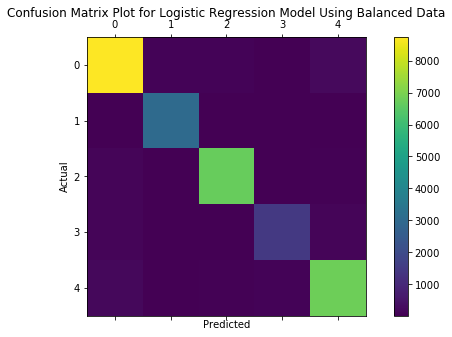

In [38]:
# Nice plot of confusion matrix
# Adjust size of confusion matrix by following code taken from StackOverflow
# https://stackoverflow.com/questions/43021762/matplotlib-how-to-change-figsize-for-matshow
plt.figure(figsize=(10,5))
plt.matshow(cm, fignum=1)

plt.title('Confusion Matrix Plot for Logistic Regression Model Using Balanced Data')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

## Decision Tree Classifier

In [39]:
from sklearn.tree import DecisionTreeClassifier
#dtc = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
dtc = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
predictions = dtc.predict(X_test)
print("Decision Tree Classifier Score: {:.2f}".format(dtc.score(X_test, y_test)))

Decision Tree Classifier Score: 0.96


In [41]:
# Generate Confusion Matrix for Decision Tree Classifier
actual = y_test
predictions = dtc.predict(X_test)
print('Confusion Matrix for Decision Tree Model Using Unbalanced Dataset')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Decision Tree Model Using Unbalanced Dataset

[[8891   54  103   40  137]
 [  82 2985    8   16   29]
 [ 103   16 6758   21   59]
 [  87   14   28 1582   69]
 [ 130   19   70   78 6944]]


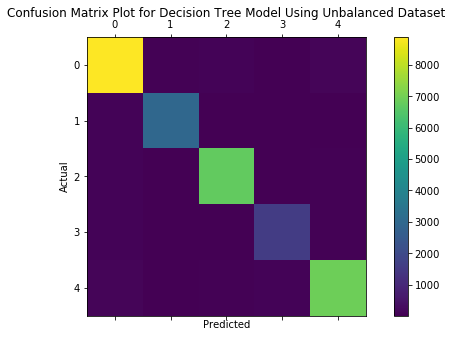

In [42]:
# plot of confusion matrix
plt.figure(figsize=(10,5))
plt.matshow(cm, fignum=1)

plt.title('Confusion Matrix Plot for Decision Tree Model Using Unbalanced Dataset')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()